In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from pic_utils import load_data

In [2]:
trainNum = 400
testNum = 100

In [3]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_data(trainNum, testNum)

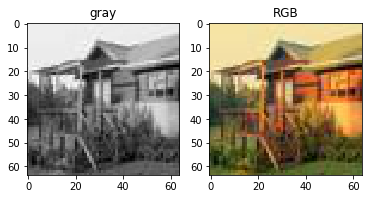

In [4]:
index = 45
plt.subplot(1,2,1)
plt.title("gray")
plt.imshow(train_set_x_orig[index].astype(np.uint8), cmap ='gray')

plt.subplot(1,2,2)
plt.title("RGB")
plt.imshow(train_set_y_orig[index].astype(np.uint8))

In [5]:
print("Number of training examples:" + str(trainNum))
print("Number of testing examples:" + str(testNum))
print("train_set_x_orig: " + str(train_set_x_orig.shape))
print("train_set_y_orig: " + str(train_set_y_orig.shape))
print("test_set_x_orig: " + str(test_set_x_orig.shape))
print("test_set_y_orig: " + str(test_set_y_orig.shape))

Number of training examples:400
Number of testing examples:100
train_set_x_orig: (400, 64, 64)
train_set_y_orig: (400, 64, 64, 3)
test_set_x_orig: (100, 64, 64)
test_set_y_orig: (100, 64, 64, 3)


In [6]:
# def softmax(x):
    
#     x_exp = np.exp(x)
#     x_sum = np.sum(x_exp, axis = 1, keepdims = True)
#     s = x_exp/x_sum
#     cache = x
#     return s, cache

In [7]:
# def softmax_backward(dA, cache):
#     return dA, cache

In [8]:
def flat_stan(x):
    set_x_flatten = x.reshape(x.shape[0],-1).T
    stan_x = set_x_flatten/255.
    return stan_x

In [9]:
def de_flat_stan(imgArr):
    f_x = imgArr * 255.
    x = f_x.reshape(64, 64,3)
    return x

In [10]:
train_x = flat_stan(train_set_x_orig)
train_y = flat_stan(train_set_y_orig)
test_x = flat_stan(test_set_x_orig)
test_y = flat_stan(test_set_y_orig)

print("train_x shape: ", train_x.shape)
print("train_y shape: ", train_y.shape)
print("test_x shape: ", test_x.shape)
print("test_y shape: ", test_y.shape)

train_x shape:  (4096, 400)
train_y shape:  (12288, 400)
test_x shape:  (4096, 100)
test_y shape:  (12288, 100)


In [11]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1, 
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

In [52]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        #print("W" + str(l))
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

In [13]:
def linear_forward(A,W,b):
    Z = np.dot(W,A) + b
    cache = (A, W, b)
    return Z, cache

In [14]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

In [15]:
def sigmoid(Z): 
    A = 1/(1+np.exp(-Z))
    cache=Z
    return A, cache

In [36]:
def linear_activation_forward(A_prev, W, b, activation):
#     if activation == "softmax":
#         Z, linear_cache = linear_forward(A_prev, W, b)
#         A, activation_cache = softmax(Z)
    
    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    elif activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

In [37]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)
    
    return AL, caches

In [18]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = 1/m * np.sum(1/2*np.square(AL - Y))
    return cost

In [19]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis =1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [20]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z<=0] = 0
    return dZ

In [21]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

In [22]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db
        

In [23]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - 1/m*(Y-AL)
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid"
                                                                                                   )
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp
        
    return grads
        

In [24]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - np.multiply(learning_rate, grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    return parameters

In [25]:
n_x = 4096
n_y = 12288
layers_dims = (n_x, 1024, 6400, 8192, n_y)

In [66]:
def L_layer_model(X,Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    
    costs = []

    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
                
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
        if i>200 and costs[-1] >= costs[-2]:
            learning_rate /=2
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title('Learning rate =' + str(learning_rate))
    plt.show()
        
    return parameters

In [73]:
for para in parameters:
    np.savetxt('parameters/'+str(para)+'.csv', parameters[para], delimiter = ',')

In [90]:
def predict(X, Y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2      
    trans, caches = L_model_forward(X, parameters)
    
    return trans
    
#     plt.subplot(1,3,1)
#     plt.title("origin")
#     plt.imshow(test_set_x_orig[index].astype(np.uint8), cmap ='gray')
    
#     print(AL.shape)
    
#     plt.subplot(1,3,2)
#     plt.title("predict")
#     plt.imshow(de_flat_stan(AL).astype(np.uint8))
    
    
    
#     plt.subplot(1,3,3)
#     plt.title("True")
#     plt.imshow(test_set_y_orig[index].astype(np.uint8))

In [91]:
trans_img = predict(test_x, test_y, parameters)

In [97]:
def print_contrast(index, trans_img):
    plt.subplot(1,3,1)
    plt.title("origin")
    plt.imshow(test_set_x_orig[index].astype(np.uint8), cmap ='gray')
    
    plt.subplot(1,3,2)
    plt.title("predict")
    plt.imshow(de_flat_stan(trans_img[:,index]).astype(np.uint8))
        
    plt.subplot(1,3,3)
    plt.title("True")
    plt.imshow(test_set_y_orig[index].astype(np.uint8))
    

### <font face = "Times New Roman"><font size = "4"> Assessing the basic nn based on rgb space</font>

+ <font face = "Times New Roman"><font size = "3">Basicly, RGB space is very intuitive for our to understands and it is also the basic way for computer to show pictures.</font>
    
+ <font face = "Times New Roman"><font size = "3"> Contrary to the lab space, the rgb space is quite good on seperating color boundaries in the picture.</font>
        
+ <font face = "Times New Roman"><font size = "3"> The draw back for this method is that when we build the function for this, we will loss the information of lines and structures in the picuture. It is hard for this RGB model to re-capture the structure information of the image, we can see it bellow.</font>

(12288,)


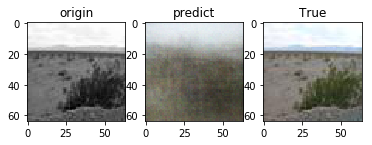

In [96]:
index =78
print_contrast(index, trans_img)

Cost after iteration 0: 443.3034356511034
Cost after iteration 100: 374.95029965752855
Cost after iteration 200: 334.1128927942292
Cost after iteration 300: 288.66814187802595
Cost after iteration 400: 262.252467361984
Cost after iteration 500: 251.0029330294563
Cost after iteration 600: 235.84849693879312
Cost after iteration 700: 215.56695211804308
Cost after iteration 800: 213.25263579129464
Cost after iteration 900: 205.10203682260266
Cost after iteration 1000: 199.93300059160669
Cost after iteration 1100: 191.6589496488975
Cost after iteration 1200: 181.31808649543967
Cost after iteration 1300: 185.1147009840733
Cost after iteration 1400: 166.9522479465726
Cost after iteration 1500: 166.9522479465726
Cost after iteration 1600: 166.9522479465726
Cost after iteration 1700: 166.9522479465726
Cost after iteration 1800: 166.9522479465726
Cost after iteration 1900: 166.9522479465726
Cost after iteration 2000: 166.9522479465726
Cost after iteration 2100: 166.9522479465726
Cost after iter

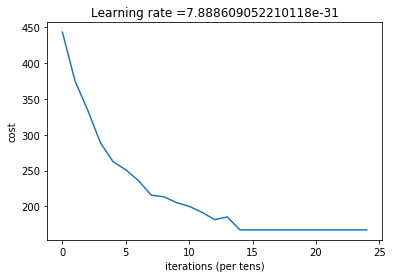

In [68]:
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 1, num_iterations = 2500, print_cost = True)

+ <font face = "Times New Roman"><font size = "3">Besides, we can see that, the loss function drops very slow, and it meets the critical point at a relatively high value: 166.95</font>

### To modify this method, later we seperate the image into three graph which is red, green and blue, and train the model seperately for them. The result have a better cost value and better result.